In [45]:
# Based on Amar's matlab code
import numpy as np
from shapely.geometry import LineString, Point

import time

parameters = {}

parameters['time'] = time.strftime('%d%b%H%M', time.localtime())
parameters['doi_size'] = 1.5
parameters['alpha'] = 1e2
parameters['num_iter'] = 1,
parameters['num_devices'] = 20
parameters['device_indices'] = [x+1 for x in range(parameters['num_devices'])]

parameters['sample_rate'] = 1e6  # Hz
parameters['num_samples'] = 1000  # number of samples per call to rx()
parameters['center_freq'] = 2.4e9  # Hz 2.4e9
parameters['bandwidth'] = 10  # Hz
parameters['transmitter_attenuation'] = 0  # dB
parameters['receiver_gain'] = 40,  # dB
parameters['grid_resolution'] = 0.05
parameters['detection_size'] = 0.1

def calculate_distance(point1, point2):
    return np.sqrt((point1[0]-point2[0])**2+(point1[1]-point2[1])**2)



def get_device_coordinates(parameters):
    doi_size = parameters['doi_size']
    num_deivces = len(parameters['device_indices'])

    line = LineString(((0.0, 0.0), (0.0, doi_size), (doi_size, doi_size), (doi_size, 0.0), (0.0, 0.0)))

    distances = np.linspace(0, line.length, num_deivces+1)

    points = [line.interpolate(distance) for distance in distances[:-1]]

    xx = [round(point.x, 3) for point in points]
    yy = [round(point.y, 3) for point in points]

    return xx, yy


def get_grid_coordinates(parameters):
    x = np.linspace(0.025, 1.475, int(parameters['doi_size']/parameters['grid_resolution']))

    y = np.linspace(0.025, 1.475, int(parameters['doi_size']/parameters['grid_resolution']))

    xx, yy = np.meshgrid(x, y)

    return xx, yy


device_xx, device_yy = get_device_coordinates(parameters)


grid_xx, grid_yy = get_grid_coordinates(parameters)

dist_txrx = np.zeros((parameters['num_devices'], parameters['num_devices']))
for tx in range(parameters['num_devices']):
    for rx in range(parameters['num_devices']):
        dist_txrx[tx][rx] = calculate_distance((device_xx[tx], device_yy[tx]), (device_xx[rx], device_yy[rx]))

dist_grid2device = np.zeros((int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution']), parameters['num_devices']))
for y in range(int(parameters['doi_size']/parameters['grid_resolution'])):
    for x in range(int(parameters['doi_size']/parameters['grid_resolution'])):
        for device in range(parameters['num_devices']):
            dist_grid2device[x][y][device] = (calculate_distance((grid_xx[x][y], grid_yy[x][y]), (device_xx[device], device_yy[device])))


In [46]:
F_RTI = np.zeros(((parameters['num_devices'])*(parameters['num_devices']-1), int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution'])))

idx = 0
for tx in range(parameters['num_devices']):
    for rx in range(parameters['num_devices']):
        if tx != rx:
            Thresh = 2*np.sqrt(dist_txrx[tx][rx]**2/4+parameters['detection_size']**2)
            foc_sum = dist_grid2device[:, :, rx] + dist_grid2device[:, :, tx]
            foc_sum[foc_sum>Thresh]=0
            foc_sum[foc_sum!=0]=1
            F_RTI[idx] = foc_sum
            idx += 1

F_RTI = F_RTI.reshape((parameters['num_devices'])*(parameters['num_devices']-1), -1)

In [47]:
start = time.time()

In [48]:
from functions import *

Pinc = np.load('result/Pinc.npy')
Pinc = magnitude_to_db(abs(np.mean(np.squeeze(Pinc), axis=2)), parameters['receiver_gain'])
Pinc = Pinc[~np.eye(Pinc.shape[0],dtype=bool)].reshape(-1,1)

In [49]:
Ptot = np.load('result/Ptot.npy')
Ptot = magnitude_to_db(abs(np.mean(np.squeeze(Ptot), axis=2)), parameters['receiver_gain'])
Ptot = Ptot[~np.eye(Ptot.shape[0],dtype=bool)].reshape(-1,1)

In [50]:
Pryt = Pinc - Ptot

In [51]:
output = np.matmul(np.linalg.solve((np.matmul(F_RTI.T, F_RTI) + parameters['alpha'] * np.identity((int(parameters['doi_size']/parameters['grid_resolution'])**2))),  F_RTI.T), Pryt)

In [52]:
output = output / output.max()

In [53]:
output[output<0] = 0

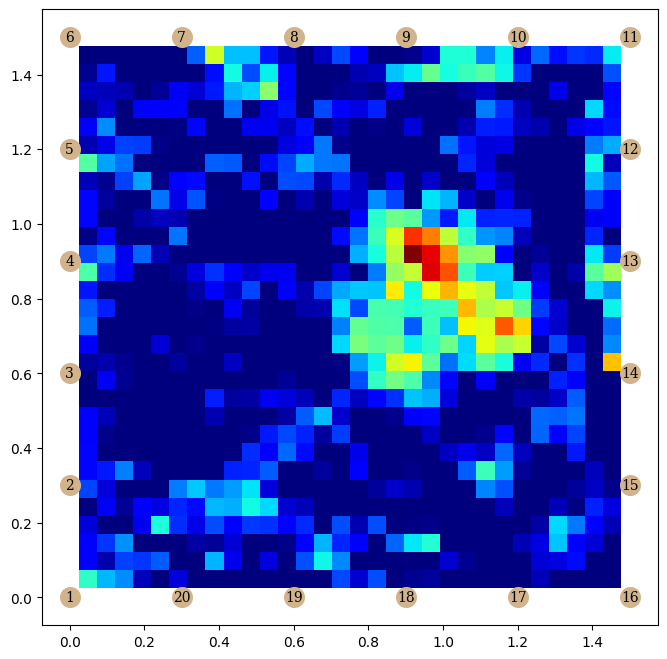

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

fontdict = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 10,
            }

plt.imshow(output.reshape((30,30)), extent=[0.025, 1.475, 0.025, 1.475], cmap='jet')

for i in range(parameters['num_devices']):
    plt.scatter(device_xx[i], device_yy[i], c='tan', s=200)
    plt.text(x=device_xx[i], y=device_yy[i]-0.01, s=i+1, fontdict=fontdict, ha='center')
plt.show()

In [55]:
import numpy as np
import time

parameters = {}

parameters['time'] = time.time()
parameters['num_devices'] = 20
parameters['device_indices'] = [x+1 for x in range(parameters['num_devices'])]

# device parameters
parameters['sample_rate'] = 1e6  # Hz
parameters['num_samples'] = 100  # number of samples per call to rx()
parameters['center_freq'] = 2.4e9  # Hz
parameters['bandwidth'] = 10  # Hz
parameters['transmitter_attenuation'] = 0  # dB
parameters['receiver_gain'] = 30  # dB
parameters['wavelength'] = 3e8/parameters['center_freq']

# imaging parameters
parameters['doi_size'] = 1.5
parameters['alpha'] = 0.05 #1e2
parameters['grid_resolution'] = 0.05
parameters['detection_size'] = 0.1
parameters['pixel_size'] = (int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution'])) 

parameters['eterm'] = 1
parameters['k0'] = 2*np.pi/parameters['wavelength']

    
Pinc = np.load('result/Pinc.npy')
Ptot = np.load('result/Ptot.npy')

Pinc = magnitude_to_db(abs(np.mean(np.squeeze(Pinc), axis=2)), parameters['receiver_gain'])
Pinc = Pinc[~np.eye(Pinc.shape[0],dtype=bool)].reshape(-1,1)


Ptot = magnitude_to_db(abs(np.mean(np.squeeze(Ptot), axis=2)), parameters['receiver_gain'])
Ptot = Ptot[~np.eye(Ptot.shape[0],dtype=bool)].reshape(-1,1)

In [56]:
Pryt=(Ptot-Pinc)/(20*np.log10(np.exp(1)))

In [57]:
cellrad = (np.sqrt(parameters['grid_resolution']**2/np.pi)*2)/2

In [58]:
from scipy.special import hankel1, jv

E_d = (1j/4)*hankel1(0, parameters['k0']*dist_txrx)
E_inc = (1j/4)*hankel1(0, parameters['k0']*dist_grid2device)

In [59]:
E_d.shape
dist_txrx.shape


(20, 20)

In [60]:
E_inc.shape

(30, 30, 20)

In [61]:
Zryt.shape

NameError: name 'Zryt' is not defined

In [ ]:
Zryt=((1j*np.pi*cellrad/(2*parameters['k0']))*jv(1,parameters['k0']*cellrad)*hankel1(0, parameters['k0']*dist_grid2device.T))

In [ ]:
Fryt = np.zeros(((parameters['num_devices'])*(parameters['num_devices']-1), int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution'])), dtype=complex)

idx = 0
for tx in range(parameters['num_devices']):
    for rx in range(parameters['num_devices']):
        if tx != rx:
            Fryt[idx] = ((parameters['k0']**2)*((Zryt[rx, :, :]*(E_inc[:, :, tx]).T)/(E_d[tx][rx])))
            
            idx += 1

In [ ]:
FrytB = np.concatenate((Fryt.real, -Fryt.imag)).reshape(380, -1)

In [ ]:
FrytB.T.shape

In [ ]:
U_l = FrytB.shape[1]

In [ ]:
lambda_max = np.linalg.norm(np.matmul(FrytB.T, Pryt), ord=2)

In [ ]:
(np.matmul(FrytB.T, FrytB) + lambda_max * parameters['alpha'] * np.identity(U_l))

In [ ]:
# O = (FrytB.'*FrytB + lambda_max*alph*eye(U_l))\FrytB.'*Pryt

Oimag = np.matmul(np.linalg.solve((np.matmul(FrytB.T, FrytB) + lambda_max * parameters['alpha'] * np.identity(U_l)),  FrytB.T), Pryt)[parameters['pixel_size'][0]**2:]

In [ ]:
epr = 4*np.pi*(Oimag*0.5)/parameters['wavelength']

epr[epr < 0] = 0

In [ ]:

plt.figure(figsize=(8, 8))

fontdict = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 10,
            }

plt.imshow(epr.reshape((30,30)), extent=[0.025, 1.475, 0.025, 1.475], cmap='jet')

for i in range(parameters['num_devices']):
    plt.scatter(device_xx[i], device_yy[i], c='tan', s=200)
    plt.text(x=device_xx[i], y=device_yy[i]-0.01, s=i+1, fontdict=fontdict, ha='center')
plt.show()

In [ ]:
epr.max()

In [ ]:
import scipy.io


haha = scipy.io.loadmat("/home/lowong/Downloads/Forward_and_inverse_xPRA_RTI_codes - Anders/distanceED.mat")['distRxRn']

haha = np.array(haha)
haha.shape


In [ ]:
dist_grid2device.shape

In [ ]:
dist_grid2device.reshape(900, -1).T - haha

In [ ]:
name = "ssaeesd"
typed = "sssaaeedd"

In [ ]:
len(name)

7

In [ ]:
name = [x for x in name]
typed = [x for x in typed]
name[1:]

['s', 'a', 'e', 'e', 's', 'd']

In [ ]:
def isLongPressedName(name: str, typed: str) -> bool:
    while len(name)>0 and len(typed)>0:
        print(name)
        print(typed)
        if name[0] != typed[0]:
            return False

        n_count = 1
        if len(name)!=1:
            for n in range(1, len(name)):
                if name[0] == name[n]:
                    n_count += 1
                else:
                    break
        
        t_count = 1
        if len(typed)!=1:
            for t in range(1, len(typed)):
                if typed[0] == typed[t]:
                    t_count += 1
                else:
                    break
        
        if n_count > t_count:
            return False
        else:
            name = name[n_count:]
            typed = typed[t_count:]

    if len(typed)>0 or len(name)>0:
        return False
    else:
        return True

isLongPressedName(name =
"alexd", typed =
"ale")

alexd
ale
lexd
le
exd
e


False

In [ ]:
"xd"[0]

'x'